## 特征选择 (feature_selection) 

#### Filter  

1. 移除低方差的特征 (Removing features with low variance)
2. 单变量特征选择 (Univariate feature selection)  

#### Wrapper  

3. 递归特征消除 (Recursive Feature Elimination)  

#### Embedded  

4. 使用SelectFromModel选择特征 (Feature selection using SelectFromModel)
5. 将特征选择过程融入pipeline (Feature selection as part of a pipeline)

当数据预处理完成后，我们需要选择有意义的特征输入机器学习的算法和模型进行训练。  

通常来说，从两个方面考虑来选择特征：

#### 特征是否发散  
如果一个特征不发散，例如方差接近于0，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用。

#### 特征与目标的相关性
这点比较显见，与目标相关性高的特征，应当优选选择。除移除低方差法外，本文介绍的其他方法均从相关性考虑。

根据特征选择的形式又可以将特征选择方法分为3种：

- Filter：过滤法，按照发散性或者相关性对各个特征进行评分，设定阈值或者待选择阈值的个数，选择特征。
- Wrapper：包装法，根据目标函数（通常是预测效果评分），每次选择若干特征，或者排除若干特征。
- Embedded：嵌入法，先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据系数从大到小选择特征。类似于Filter方法，但是是通过训练来确定特征的优劣。  


特征选择主要有两个目的：

- 减少特征数量、降维，使模型泛化能力更强，减少过拟合；  

- 增强对特征和特征值之间的理解。

拿到数据集，一个特征选择方法，往往很难同时完成这两个目的。通常情况下，选择一种自己最熟悉或者最方便的特征选择方法（往往目的是降维，而忽略了对特征和数据理解的目的）。接下来将结合 Scikit-learn提供的例子 介绍几种常用的特征选择方法，它们各自的优缺点和问题。

### Filter

#### 1）移除低方差的特征 (Removing features with low variance)  

假设某特征的特征值只有0和1，并且在所有输入样本中，95%的实例的该特征取值都是1，那就可以认为这个特征作用不大。如果100%都是1，那这个特征就没意义了。当特征值都是离散型变量的时候这种方法才能用，如果是连续型变量，就需要将连续变量离散化之后才能用。而且实际当中，一般不太会有95%以上都取某个值的特征存在，所以这种方法虽然简单但是不太好用。可以把它作为特征选择的预处理，先去掉那些取值变化小的特征，然后再从接下来提到的的特征选择方法中选择合适的进行进一步的特征选择。

In [3]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

果然, VarianceThreshold 移除了第一列特征，第一列中特征值为0的概率达到了5/6.

#### 2）单变量特征选择 (Univariate feature selection)

单变量特征选择的原理是分别单独的计算每个变量的某个统计指标，根据该指标来判断哪些变量重要，剔除那些不重要的变量。  

对于分类问题(y离散)，可采用：
- 卡方检验或者IV值
- f_classif 
- mutual_info_classif
- 互信息  

对于回归问题(y连续)，可采用：
- 皮尔森相关系数
- f_regression,
- mutual_info_regression
- 最大信息系数

这种方法比较简单，易于运行，易于理解，通常对于理解数据有较好的效果（但对特征优化、提高泛化能力来说不一定有效）。  

- SelectKBest 移除得分前 k 名以外的所有特征(取top k)
- SelectPercentile 移除得分在用户指定百分比以后的特征(取top k%)
- 对每个特征使用通用的单变量统计检验： 假正率(false positive rate) SelectFpr, 伪发现率(false discovery rate) SelectFdr, 或族系误差率 SelectFwe.
- GenericUnivariateSelect 可以设置不同的策略来进行单变量特征选择。同时不同的选择策略也能够使用超参数寻优，从而让我们找到最佳的单变量特征选择策略。

Notice:  
　　The methods based on F-test estimate the degree of linear dependency between two random variables. (F检验用于评估两个随机变量的线性相关性)On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.(另一方面，互信息的方法可以捕获任何类型的统计依赖关系，但是作为一个非参数方法，估计准确需要更多的样本)

#### 卡方(Chi2)检验  

经典的卡方检验是检验定性自变量对定性因变量的相关性。比如，我们可以对样本进行一次chi2 测试来选择最佳的两项特征：

In [4]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
iris = load_iris()
X, y = iris.data, iris.target
X.shape

(150, 4)

In [5]:
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

(150, 2)

#### Pearson相关系数 (Pearson Correlation)

皮尔森相关系数是一种最简单的，能帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性，结果的取值区间为[-1，1]，-1表示完全的负相关，+1表示完全的正相关，0表示没有线性相关。

In [8]:
import numpy as np
from scipy.stats import pearsonr
np.random.seed(0)
size = 300
x = np.random.normal(0, 1, size)
# pearsonr(x, y)的输入为特征矩阵和目标向量，能够同时计算 相关系数 和p-value.
print("Lower noise", pearsonr(x, x + np.random.normal(0, 1, size)))
print("Higher noise", pearsonr(x, x + np.random.normal(0, 10, size)))

Lower noise (0.7182483686213841, 7.32401731299835e-49)
Higher noise (0.057964292079338155, 0.3170099388532475)


这个例子中，我们比较了变量在加入噪音之前和之后的差异。当噪音比较小的时候，相关性很强，p-value很低。

我们使用Pearson相关系数主要是为了看特征之间的相关性，而不是和因变量之间的。

### Wrapper

#### 递归特征消除 (Recursive Feature Elimination)

递归消除特征法使用一个基模型来进行多轮训练，每轮训练后，移除若干权值系数的特征，再基于新的特征集进行下一轮训练。  

对特征含有权重的预测模型(例如，线性模型对应参数coefficients)，RFE通过递归减少考察的特征集规模来选择特征。首先，预测模型在原始特征上训练，每个特征指定一个权重。之后，那些拥有最小绝对值权重的特征被踢出特征集。如此往复递归，直至剩余的特征数量达到所需的特征数量。  

RFECV 通过交叉验证的方式执行RFE，以此来选择最佳数量的特征：对于一个数量为d的feature的集合，他的所有的子集的个数是2的d次方减1(包含空集)。指定一个外部的学习算法，比如SVM之类的。通过该算法计算所有子集的validation error。选择error最小的那个子集作为所挑选的特征。

In [29]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

rf = RandomForestClassifier()
iris=load_iris()
X,y=iris.data,iris.target
rfe = RFE(estimator=rf, n_features_to_select=3)
X_rfe = rfe.fit_transform(X,y)
X_rfe.shape

C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(150, 3)

In [30]:
X_rfe[:5,:]

array([[5.1, 1.4, 0.2],
       [4.9, 1.4, 0.2],
       [4.7, 1.3, 0.2],
       [4.6, 1.5, 0.2],
       [5. , 1.4, 0.2]])

### Embedded

使用SelectFromModel选择特征 (Feature selection using SelectFromModel)

#### 基于L1的特征选择 (L1-based feature selection)  

使用L1范数作为惩罚项的线性模型(Linear models)会得到稀疏解：大部分特征对应的系数为0。当你希望减少特征的维度以用于其它分类器时，可以通过 feature_selection.SelectFromModel 来选择不为0的系数。  

特别指出，常用于此目的的稀疏预测模型有 linear_model.Lasso（回归）， linear_model.LogisticRegression 和 svm.LinearSVC（分类）

In [31]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X,y)
model = SelectFromModel(lsvc, prefit=True)
X_embed = model.transform(X)
X_embed.shape

C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(150, 3)

In [32]:
X_embed[:5,:]

array([[5.1, 3.5, 1.4],
       [4.9, 3. , 1.4],
       [4.7, 3.2, 1.3],
       [4.6, 3.1, 1.5],
       [5. , 3.6, 1.4]])

#### 那么工作中我们更倾向于使用什么方法呢？

首先来回顾一下我们在业务中的模型会遇到什么问题。

- 模型效果不好
- 训练集效果好，跨时间测试效果不好 —— 首先应该做跨时间测试
- 跨时间测试效果也好，上线之后效果不好 —— 变量逻辑出了问题
- 上线之后效果还好，几周之后分数分布开始下滑 —— 模型效果不行，这是征兆，有几个变量在跨时间测试效果不好
- 一两个月内都比较稳定，突然分数分布骤降 —— 关注外部环境，看看国家出台了什么政策，是不是运营拉新了
- 没有明显问题，但模型每个月逐步失效




然后我们来考虑一下业务所需要的变量是什么。

- 变量必须对模型有贡献，也就是说必须能对客群加以区分
- 逻辑回归要求变量之间线性无关
- 逻辑回归评分卡也希望变量呈现单调趋势 （有一部分也是业务原因，但从模型角度来看，单调变量未必一定比有转折的变量好）
- 客群在每个变量上的分布稳定，分布迁移无可避免，但不能波动太大  

为此我们从上述方法中找到最贴合当前使用场景的几种方法。

In [29]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,label,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


1）变量重要性

- IV值
- 卡方检验
- 模型筛选

这里我们使用IV值或者模型筛选多一点

IV其实就是在WOE前面加上一项。
- $p_{y_i}=\frac{y_i}{y_T}$  
- $p_{n_i}=\frac{n_i}{n_T}$  
- $woe_i = ln(\frac{p_{y_i}}{p_{n_i}})$  
- $iv_i = (p_{y_i} - p_{n_i}) \times woe_i$    

最后只需要将每一个区间的iv加起来就得到总的iv值：
$$IV = \sum iv_i$$

In [40]:
a = 0.4  
b = 0.6
iv = (a - b) * math.log(a / b)

分箱、WOE、IV

In [4]:
import numpy as np
import pandas as pd
from scipy import stats

def mono_bin(Y,X,n=20):
    r=0
    good = Y.sum()
    bad = Y.count()-good
    while np.abs(r)< 1:
        d1=pd.DataFrame({"X":X,"Y":Y,"Bucket":pd.qcut(X,n)})
        d2=d1.groupby('Bucket',as_index=True)
        r,p=stats.spearmanr(d2.mean().X,d2.mean().Y)
        n=n-1
    d3=pd.DataFrame(d2.X.min(),columns=['min'])
    d3['min']=d2.min().X
    d3['max']=d2.max().X
    d3['sum']=d2.sum().Y
    d3['total']=d2.count().Y
    d3['rate']=d2.mean().Y
    d3['woe']=np.log((d3['rate']/(1-d3['rate']))/(good/bad))
    d3['iv']=(d3['rate']/(1-d3['rate']) - (good/bad)) * np.log((d3['rate']/(1-d3['rate']))/(good/bad))
    d4=(d3.sort_index(by='min')).reset_index(drop=True)
    print("="*60)
    print(d4)
    return d4

或者集成模型输出特征重要性：

In [ ]:
#lightGBM中的特征重要性
feature = pd.DataFrame(
            {'name' : model.booster_.feature_name(),
            'importance' : model.feature_importances_
          }).sort_values(by =  ['importance'],ascending = False)

2）共线性

- 相关系数 COR
- 方差膨胀系数 VIF  

在做很多基于空间划分思想的模型的时候，我们必须关注变量之间的相关性。单独看两个变量的时候我们会使用皮尔逊相关系数。

In [6]:
df_train.corr()

,PassengerId,label,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
label,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


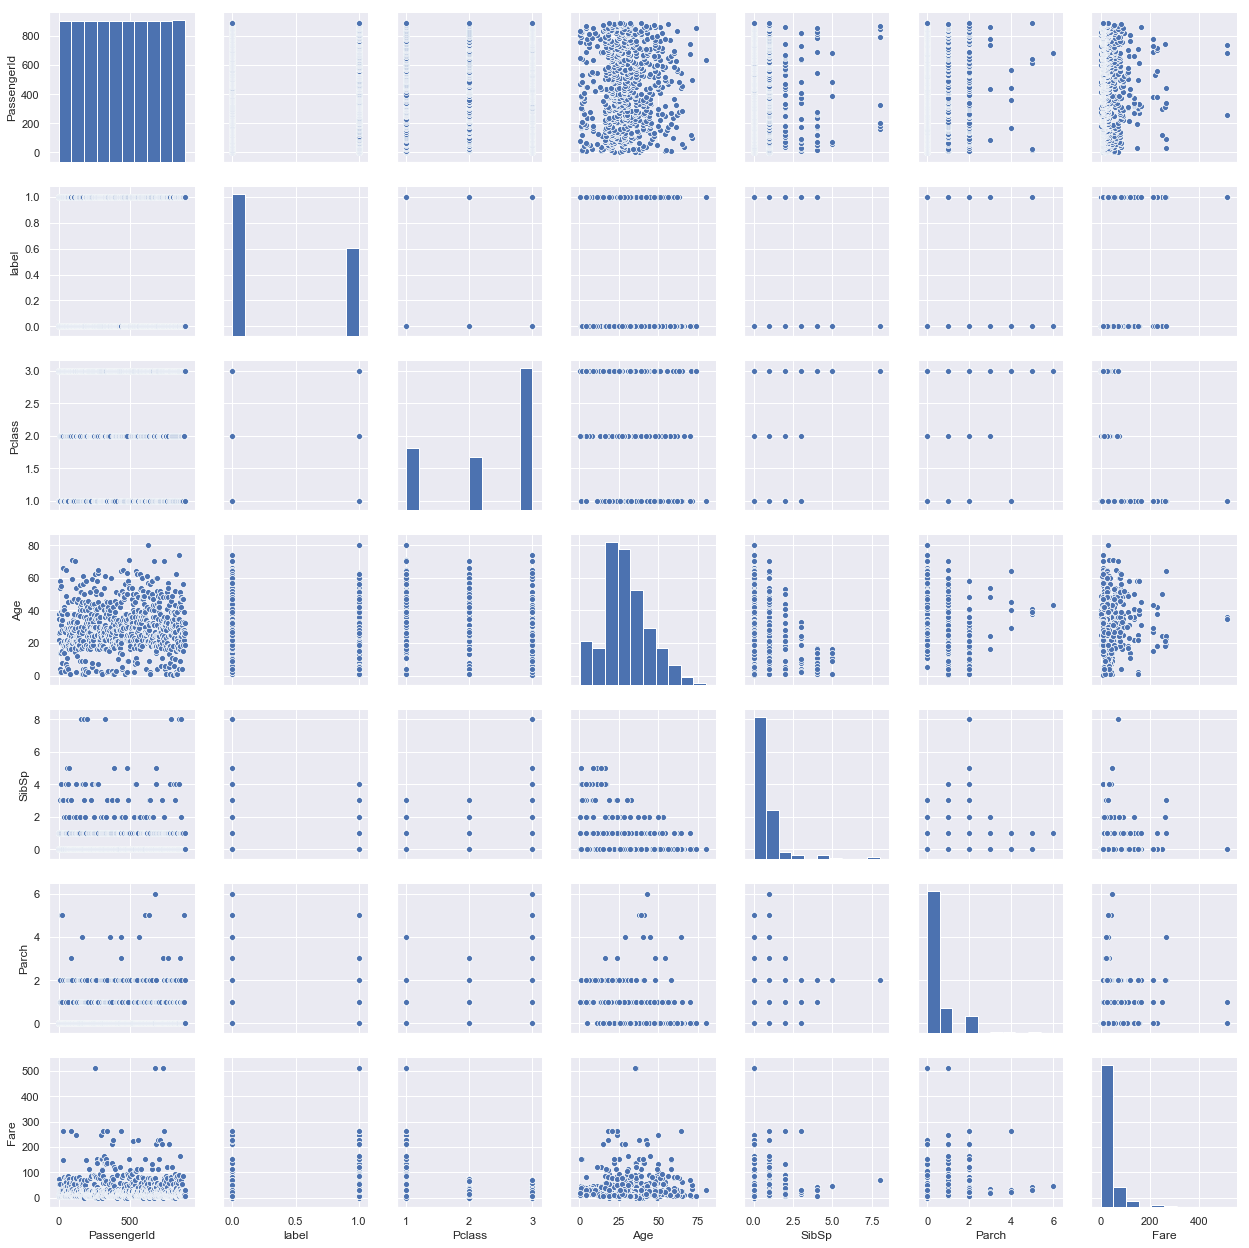

In [8]:
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "distributions")))
sns.pairplot(df_train)#对角线上是单维度分布

在多元回归中，我们可以通过计算方差膨胀系数VIF来检验回归模型是否存在严重的多重共线性问题。定义：

$$VIF = \frac{1}{1-R^2}$$

其中，$R_i$为自变量  对其余自变量作回归分析的负相关系数。方差膨胀系数是容忍度$1-R^2$的倒数。  

方差膨胀系数VIF越大，说明自变量之间存在共线性的可能性越大。一般来讲，如果方差膨胀因子超过10，则回归模型存在严重的多重共线性。又根据Hair(1995)的共线性诊断标准，当自变量的容忍度大于0.1，方差膨胀系数小于10的范围是可以接受的，表明白变量之间没有共线性问题存在。

VIF函数详细使用方法可以看[statsmodels官方文档](http://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html#statsmodels.stats.outliers_influence.variance_inflation_factor"statsmodels官方文档"). 

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

data = [[1,2,3,4,5],
        [2,4,6,8,9],
        [1,1,1,1,1],
       [2,4,6,4,7]]
X = np.array(data).T

variance_inflation_factor(X,0)

98.33333333333381

3）单调性

- bivar图

                 cut   badrate
9     (-0.001, 7.55]  0.141304
6      (7.55, 7.854]  0.298851
8      (7.854, 8.05]  0.179245
7       (8.05, 10.5]  0.230769
3     (10.5, 14.454]  0.428571
4   (14.454, 21.679]  0.420455
2     (21.679, 27.0]  0.516854
5     (27.0, 39.688]  0.373626
1   (39.688, 77.958]  0.528090
0  (77.958, 512.329]  0.758621


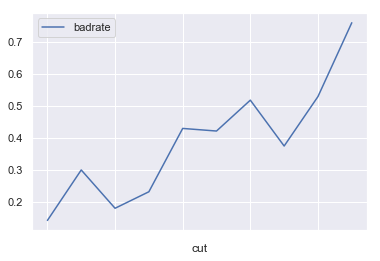

In [42]:
# 等频切分
df_train.loc[:,'fare_qcut'] = pd.qcut(df_train['Fare'], 10)
df_train.head()
df_train = df_train.sort_values('Fare')
alist = list(set(df_train['fare_qcut']))
badrate = {}
for x in alist:
    
    a = df_train[df_train.fare_qcut == x]
    
    bad = a[a.label == 1]['label'].count()
    good = a[a.label == 0]['label'].count()
    
    badrate[x] = bad/(bad+good)
f = zip(badrate.keys(),badrate.values())
f = sorted(f,key = lambda x : x[1],reverse = True )
badrate = pd.DataFrame(f)
badrate.columns = pd.Series(['cut','badrate'])
badrate = badrate.sort_values('cut')
print(badrate)
badrate.plot('cut','badrate')

4）稳定性

- PSI
- 跨时间交叉检验

#### 跨时间交叉检验

就是将样本按照月份切割，依次作为训练集和测试集来训练模型，取进入模型的变量之间的交集，但是要小心共线特征！

解决方法  

- 不需要每次都进入模型，大部分都在即可
- 先去除共线性（这也是为什么集成模型我们也会去除共线性）

#### 群体稳定性指标(population stability index)

公式： 
  
$$ PSI = \sum{(实际占比-预期占比)*{\ln(\frac{实际占比}{预期占比})}}$$

来自知乎的例子：  
比如训练一个logistic回归模型，预测时候会有个概率输出p。  
你测试集上的输出设定为p1吧，将它从小到大排序后10等分，如0-0.1,0.1-0.2,......。  
现在你用这个模型去对新的样本进行预测，预测结果叫p2,按p1的区间也划分为10等分。  
实际占比就是p2上在各区间的用户占比，预期占比就是p1上各区间的用户占比。  
意义就是如果模型跟稳定，那么p1和p2上各区间的用户应该是相近的，占比不会变动很大，也就是预测出来的概率不会差距很大。  
一般认为psi小于0.1时候模型稳定性很高，0.1-0.25一般，大于0.25模型稳定性差，建议重做。   

In [41]:
def var_PSI(dev_data, val_data):
    dev_cnt, val_cnt = sum(dev_data), sum(val_data)
    if dev_cnt * val_cnt == 0:
        return None
    PSI = 0
    for i in range(len(dev_data)):
        dev_ratio = dev_data[i] / dev_cnt
        val_ratio = val_data[i] / val_cnt + 1e-10
        psi = (dev_ratio - val_ratio) * math.log(dev_ratio/val_ratio)
        PSI += psi
    return PSI

注意分箱的数量将会影响着变量的PSI值。

PSI并不只可以对模型来求，对变量来求也一样。只需要对跨时间分箱的数据分别求PSI即可。



#### 作业：
对第二课油品数据的几个变量分别计算
- IV
- VIF
- PSI

并将变量通过bivar调整为严格单调的形式。
然后对变量进行WOE转换。